In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#from keras.utils import normalize
import os
import glob
import cv2
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

In [5]:
#Resizing images, if needed
SIZE_X = 224 
SIZE_Y = 224
n_classes=4 #Number of classes for segmentation
num_images = 12 #Total 1600 available but we can use a subset for speedy training

In [6]:
path = '//content/drive/MyDrive/train_test_full_roi/train_data/img_224'
image_names = [path+'/img{}.png'.format(k) for k in range(1,13)]

image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 1) for image in image_names_subset] #SM backbones use 3 channel images, so let us read images in color.
X_train = np.array(images)
X_train = X_train/225

In [7]:
path = '/content/drive/MyDrive/train_test_full_roi/train_data/msk_224'
mask_names = [path+'/img{}_mask2.png'.format(k) for k in range(1,13)]
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset_train = np.array(masks)


In [8]:
path = '/content/drive/MyDrive/train_test_full_roi/test_data/img_224'
image_names = [path+'/img{}.png'.format(k) for k in range(13,16)]

image_names.sort()
image_names_subset = image_names[0:num_images]
images = [cv2.imread(image, 1) for image in image_names_subset] #SM backbones use 3 channel images, so let us read images in color.
X_test = np.array(images)
X_test = X_test/225

In [9]:
path = '/content/drive/MyDrive/train_test_full_roi/test_data/msk_224'
mask_names = [path+'/img{}_mask2.png'.format(k) for k in range(13,16)]
mask_names.sort()
mask_names_subset = mask_names[0:num_images]
masks = [cv2.imread(mask, 0) for mask in mask_names_subset]
mask_dataset_test = np.array(masks)

In [10]:
#Encode labels to 0, 1, 2, 3, ... but multi dim array so need to flatten, encode and reshape
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = mask_dataset_train.shape  
mask_dataset_reshaped = mask_dataset_train.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
y_train = mask_dataset_reshaped_encoded.reshape(n, h, w)

n, h, w = mask_dataset_test.shape  
mask_dataset_reshaped = mask_dataset_test.reshape(-1,1)
mask_dataset_reshaped_encoded = labelencoder.fit_transform(mask_dataset_reshaped)
y_test = mask_dataset_reshaped_encoded.reshape(n, h, w)


/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:

print("Total images in the original dataset are: ", len(image_names))
print("Image train data shape is: ", X_train.shape)
print("Mask train data shape is: ", y_train.shape)
print("Max pixel value in image is: ", X_train.max())
print("Labels in the mask are : ", np.unique(y_train))

Total images in the original dataset are:  3
Image train data shape is:  (12, 224, 224, 3)
Mask train data shape is:  (12, 224, 224)
Max pixel value in image is:  0.9866666666666667
Labels in the mask are :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [81]:

from keras.models import Model
from keras.applications.vgg16 import VGG16

#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
VGG_model = VGG16(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in VGG_model.layers:
	layer.trainable = False
    
VGG_model.summary()  #Trainable parameters will be 0

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [95]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D


# Define the input shape
input_shape = (224, 224, 3)

# Get the output of block3_conv3
output = VGG_model.get_layer('block1_conv2').output

# Define the model with the desired input and output layers
new_model = Model(inputs=VGG_model.input, outputs=output)

# Print the model summary
new_model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
Total params: 38,720
Trainable params: 0
Non-trainable params: 38,720
_________________________________________________________________


In [13]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D


# Define the input shape
input_shape = (224, 224, 3)

# Get the output of block3_conv3
block3_conv3 = VGG_model.get_layer('block3_conv3').output

# Add an upsampling layer followed by a convolutional layer with 256 filters
x = UpSampling2D(size=(2, 2))(block3_conv3)
x = Conv2D(256, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D(size=(2, 2))(x)
# Define the output of the model
output = x

# Define the model with the desired input and output layers
new_model = Model(inputs=VGG_model.input, outputs=output)

# Print the model summary
new_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [14]:
from keras.models import Model
from keras.applications import ResNet101

#Load VGG16 model wothout classifier/fully connected layers
#Load imagenet weights that we are going to use as feature generators
resnet_model = ResNet101(weights='imagenet', include_top=False, input_shape=(SIZE_X, SIZE_Y, 3))

#Make loaded layers as non-trainable. This is important as we want to work with pre-trained weights
for layer in resnet_model.layers:
	layer.trainable = False
    
resnet_model.summary()  #Trainable parameters will be 0

171446536/171446536 [==============================] - 10s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

In [122]:
from keras.models import Model
from keras.layers import Input, Conv2D, UpSampling2D


# Define the input shape
input_shape = (224, 224, 3)

# Get the output of block3_conv3
block_output = resnet_model.get_layer('conv4_block23_out').output

# Add an upsampling layer followed by a convolutional layer with 256 filters
x = UpSampling2D(size=(2, 2))(block_output)
x = UpSampling2D(size=(2, 2))(x)
x = UpSampling2D(size=(2, 2))(x)
x = UpSampling2D(size=(2, 2))(x)
x = Conv2D(1024, (3, 3), activation='relu', padding='same')(x)
# Define the output of the model
output = x

# Define the model with the desired input and output layers
new_model = Model(inputs=resnet_model.input, outputs=output)

# Print the model summary
new_model.summary()
    


Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [123]:
#Now, let us apply feature extractor to our training data
features = new_model.predict(X_train)

1/1 [==============================] - 119s 119s/step


In [124]:
features.shape

(12, 224, 224, 1024)

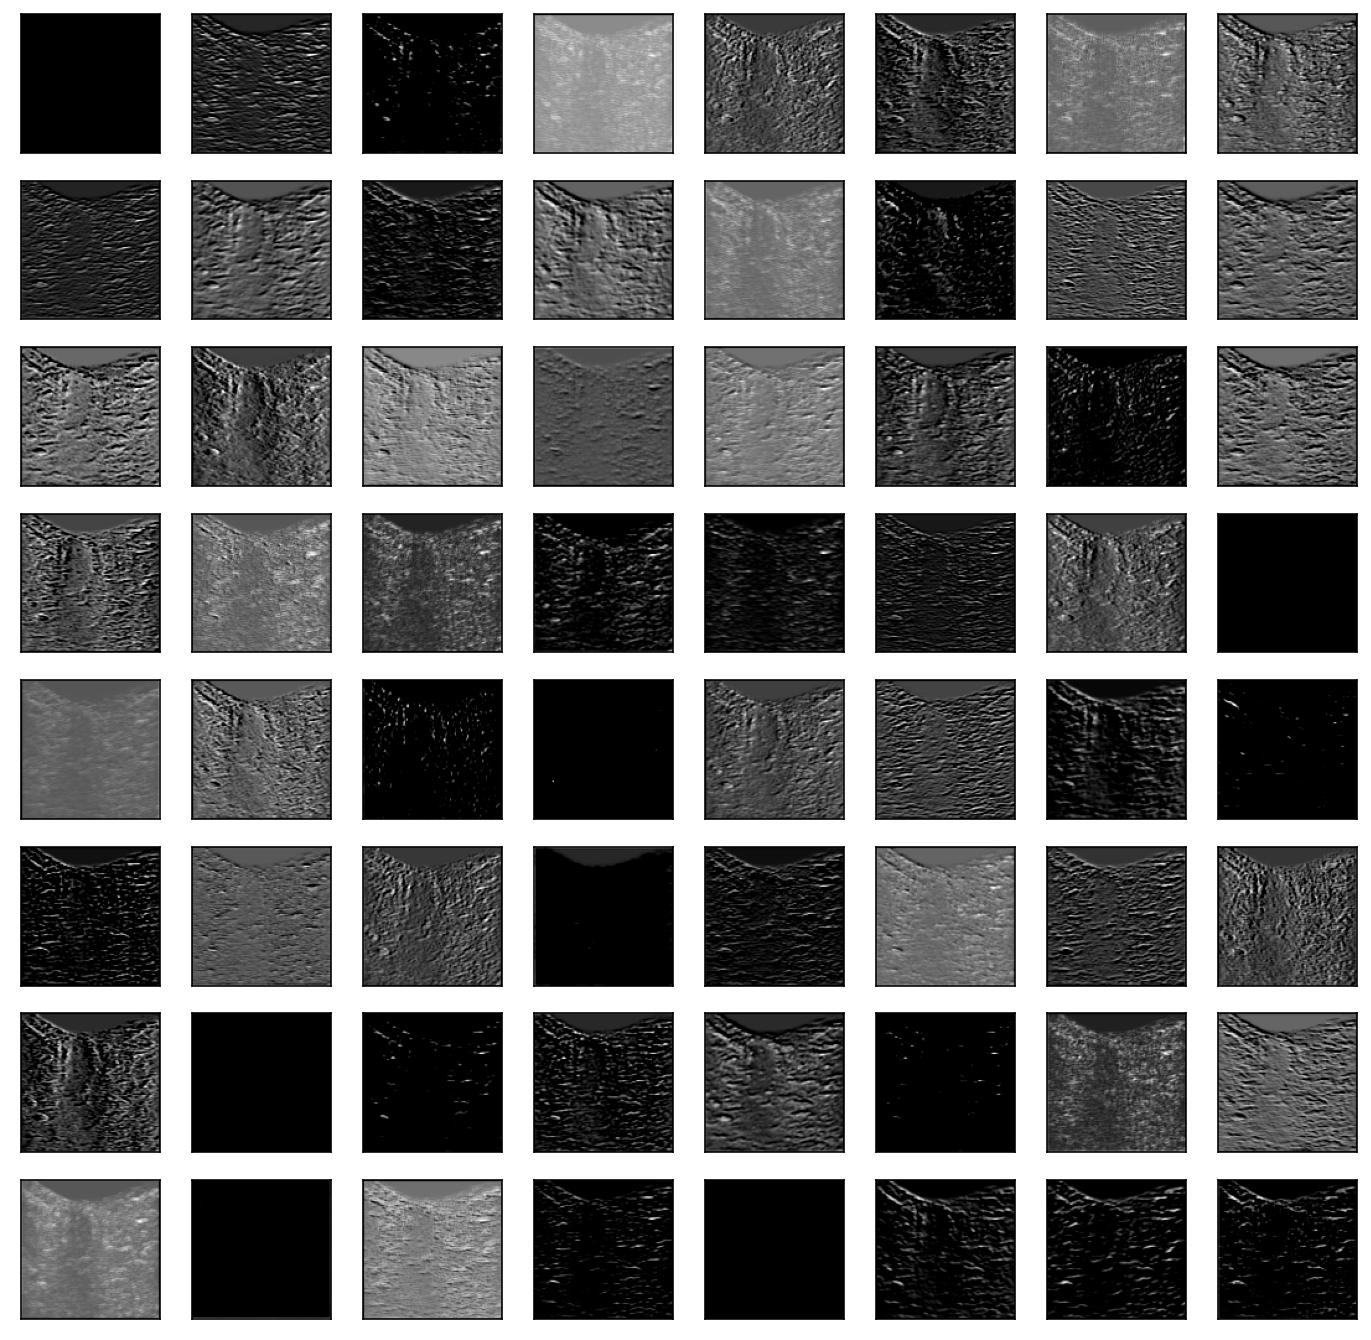

In [85]:
#Plot features to view them
plt.figure(figsize=(12, 12))
square = 8
ix=1
for _ in range(square):
    for _ in range(square):
        ax = plt.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        plt.imshow(features[0,:,:,ix-1], cmap='gray')
        ix +=1
plt.show()

In [125]:
#Reassign 'features' as X to make it easy to follow
X=features
X = X.reshape(-1, X.shape[3])  #Make it compatible for Random Forest and match Y labels
print(X.shape)

(602112, 1024)


In [126]:
#Reshape Y to match X
Y = y_train.reshape(-1)
print(Y.shape)

(602112,)


In [100]:
np.unique(Y)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [22]:
!apt-get update
!apt-get install cuda

Get:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease [3,622 B]
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Hit:5 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Get:7 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:8 http://archive.ubuntu.com/ubuntu focal InRelease
Get:9 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Get:13 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1,015 kB]
Get:14 http://archive.ubuntu.com/ubu

In [103]:
import xgboost as xgb

model = xgb.XGBClassifier(n_estimators = 10, tree_method='gpu_hist', gpu_id=0)  #Define gpu_id, otherwise it uses CPU and computation would be very slow , tree_method='gpu_hist', gpu_id=0. 

In [104]:
# Train the model on training data
model.fit(X, Y) 

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [105]:
X_test_features=new_model.predict(X_test)
X_test_features=X_test_features.reshape(-1, X_test_features.shape[3])
print(X_test_features.shape)

1/1 [==============================] - 0s 309ms/step
(150528, 64)


In [106]:
y_pred = model.predict(X_test_features)
print(y_pred.shape)

(150528,)


In [107]:
ground_truth = y_test.reshape(-1)
print(ground_truth.shape)

(150528,)


In [108]:
#Pixel accuracy - not a good metric for semantic segmentation
#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(ground_truth, y_pred))

Accuracy =  0.8401892006802721


1/1 [==============================] - 0s 23ms/step


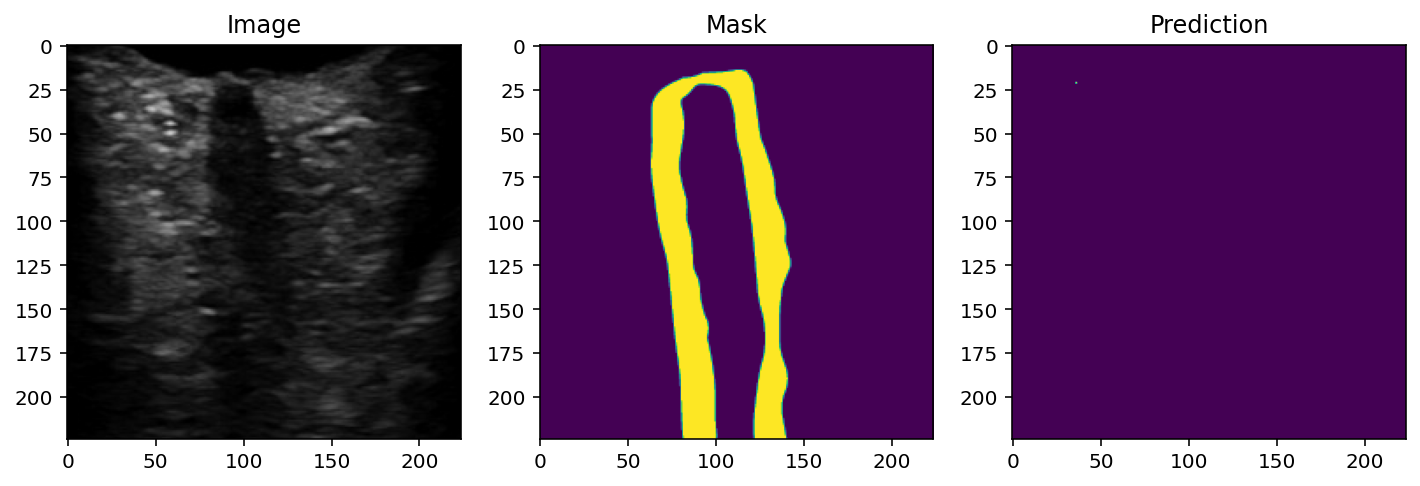

In [110]:
import random
img_number = random.randint(0, len(X_test)-1)
img = X_test[img_number]
img=np.expand_dims(img, axis=0)

img_features=new_model.predict(img)
img_features = img_features.reshape(-1, img_features.shape[3])
mask = y_test[img_number]

prediction = model.predict(img_features)
predicted_mask = prediction.reshape(mask.shape[0], mask.shape[1])

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Image')
plt.imshow(img[0], cmap='gray')
plt.subplot(232)
plt.title('Mask')
plt.imshow(mask)
plt.subplot(233)
plt.title('Prediction')
plt.imshow(predicted_mask)
plt.show()

In [101]:
features.shape

(12, 224, 224, 64)

In [127]:
import pandas as pd
import numpy as np



# reshape the 3D array to a 2D array where each row represents a pixel and each column represents a feature
df_data = features[3,:,:,:].reshape((224*224, 1024))

# create a dataframe with the reshaped data and use tuples of (i,j) as the index
df = pd.DataFrame(df_data, index=[(i, j) for i in range(224) for j in range(224)])


In [128]:
df

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
"(0, 0)",0.299223,0.0,0.902958,1.239656,0.000000,0.000000,0.531922,0.0,0.000000,0.933858,...,0.350061,0.000000,0.422352,0.661333,0.411851,0.216656,0.149261,0.854855,0.000000,1.735690
"(0, 1)",0.000000,0.0,0.915262,2.130758,0.000000,0.548368,1.449016,0.0,0.000000,0.733858,...,0.583592,0.127081,1.142960,0.316783,0.909724,0.000000,0.697118,0.000000,0.293553,1.341385
"(0, 2)",0.000000,0.0,0.915262,2.130758,0.000000,0.548368,1.449016,0.0,0.000000,0.733858,...,0.583592,0.127081,1.142960,0.316783,0.909724,0.000000,0.697118,0.000000,0.293553,1.341385
"(0, 3)",0.000000,0.0,0.915262,2.130758,0.000000,0.548368,1.449016,0.0,0.000000,0.733858,...,0.583592,0.127081,1.142960,0.316783,0.909724,0.000000,0.697118,0.000000,0.293553,1.341385
"(0, 4)",0.000000,0.0,0.915262,2.130758,0.000000,0.548368,1.449016,0.0,0.000000,0.733858,...,0.583592,0.127081,1.142960,0.316783,0.909724,0.000000,0.697118,0.000000,0.293553,1.341385
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(223, 219)",0.000000,0.0,2.630422,0.344683,0.431598,0.000000,0.785142,0.0,0.244344,1.709540,...,0.000000,0.048399,4.020106,0.000000,0.000000,1.581985,0.000000,4.344590,0.000000,1.807481
"(223, 220)",0.000000,0.0,2.630422,0.344683,0.431598,0.000000,0.785142,0.0,0.244344,1.709540,...,0.000000,0.048399,4.020106,0.000000,0.000000,1.581985,0.000000,4.344590,0.000000,1.807481
"(223, 221)",0.000000,0.0,2.630422,0.344683,0.431598,0.000000,0.785142,0.0,0.244344,1.709540,...,0.000000,0.048399,4.020106,0.000000,0.000000,1.581985,0.000000,4.344590,0.000000,1.807481
"(223, 222)",0.000000,0.0,2.630422,0.344683,0.431598,0.000000,0.785142,0.0,0.244344,1.709540,...,0.000000,0.048399,4.020106,0.000000,0.000000,1.581985,0.000000,4.344590,0.000000,1.807481


In [33]:
df=df/df.sum()
df = df.fillna(0)
df


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
"(0, 0)",0.0,0.000006,0.0,0.000000,0.000004,0.000049,0.000049,0.007984,0.0,1.0,...,1.0,0.000220,5.402311e-06,0.000000,0.000000e+00,0.000000,0.000000,0.0,0.000000,0.000000
"(0, 1)",0.0,0.000020,0.0,0.001743,0.000072,0.000057,0.000000,0.000000,0.0,0.0,...,0.0,0.001366,8.650809e-07,0.000000,0.000000e+00,0.000000,0.000033,0.0,0.000000,0.000000
"(0, 2)",0.0,0.000020,0.0,0.001743,0.000072,0.000057,0.000000,0.000000,0.0,0.0,...,0.0,0.001366,8.650809e-07,0.000000,0.000000e+00,0.000000,0.000033,0.0,0.000000,0.000000
"(0, 3)",0.0,0.000019,0.0,0.000000,0.000064,0.000047,0.000000,0.000000,0.0,0.0,...,0.0,0.000872,3.641175e-06,0.000000,0.000000e+00,0.000000,0.000024,0.0,0.000000,0.000000
"(0, 4)",0.0,0.000019,0.0,0.000000,0.000062,0.000035,0.000000,0.000000,0.0,0.0,...,0.0,0.000821,3.010616e-06,0.000000,0.000000e+00,0.000000,0.000023,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(223, 219)",0.0,0.000037,0.0,0.000855,0.000037,0.000055,0.000122,0.000000,0.0,0.0,...,0.0,0.000000,1.386472e-05,0.007028,3.858142e-05,0.000242,0.000021,0.0,0.001421,0.000011
"(223, 220)",0.0,0.000042,0.0,0.000010,0.000050,0.000034,0.000133,0.000000,0.0,0.0,...,0.0,0.000000,1.090756e-05,0.005984,3.675465e-05,0.000000,0.000002,0.0,0.001174,0.000021
"(223, 221)",0.0,0.000037,0.0,0.000000,0.000035,0.000019,0.000120,0.000000,0.0,0.0,...,0.0,0.000000,5.630430e-06,0.004946,3.326305e-05,0.000047,0.000026,0.0,0.002123,0.000008
"(223, 222)",0.0,0.000037,0.0,0.000000,0.000035,0.000019,0.000120,0.000000,0.0,0.0,...,0.0,0.000000,5.630430e-06,0.004946,3.326305e-05,0.000047,0.000026,0.0,0.002123,0.000008


In [129]:
X=df.values

In [130]:
import numpy as np
from sklearn.decomposition import PCA

pca = PCA(n_components = 2)
pca.fit(X)
X_reduced  = pca.transform(X)

X_reduced

array([[-23.541481 ,  -8.094639 ],
       [-21.61471  ,  -7.6188326],
       [-21.61471  ,  -7.6188326],
       ...,
       [ 15.580433 , -12.826191 ],
       [ 15.580433 , -12.826191 ],
       [  3.4095042, -10.846455 ]], dtype=float32)

In [131]:
from sklearn.cluster import KMeans
import numpy as np

kmeans = KMeans(n_clusters=3, random_state=0, n_init="auto").fit(X_reduced)
kmeans.labels_




array([0, 0, 0, ..., 2, 2, 0], dtype=int32)

In [132]:
Matr_image = [[0]*224 for i in range(224)]
k = 0
for i in range(224):
  for j in range(224):
    if kmeans.labels_[k] == 1:
      Matr_image[i][j] = [0,0,0]
    if kmeans.labels_[k] == 2 :
      Matr_image[i][j] = [255,255,255]
    else :
      Matr_image[i][j] = [0,0,0]
    
    k += 1


Matr_image = np.array(Matr_image)




    



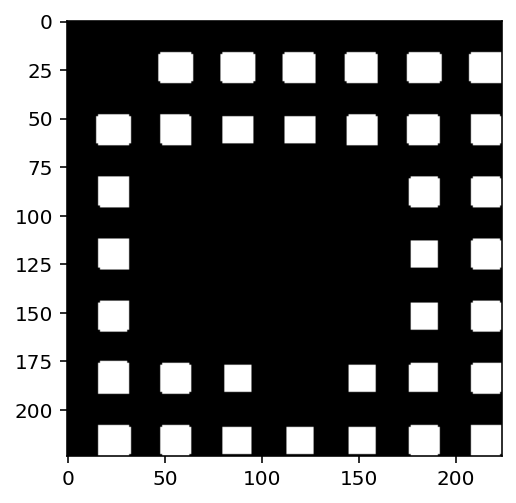

In [133]:
import matplotlib.pyplot as plt
import numpy as np

# Load the RGB image array
image = Matr_image
# Plot the RGB image
plt.imshow(image)
plt.show()

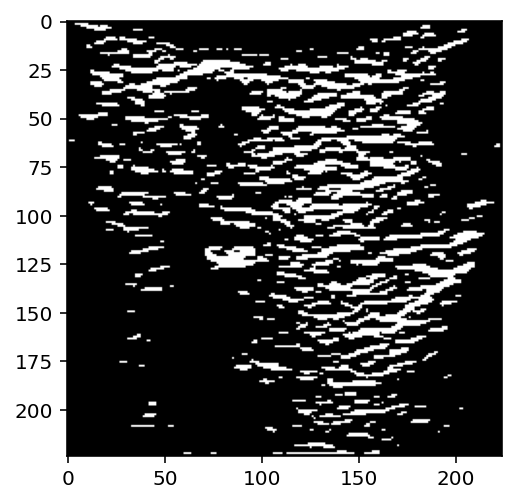

In [120]:
import matplotlib.pyplot as plt
import numpy as np

# Load the RGB image array
image = Matr_image
# Plot the RGB image
plt.imshow(image)
plt.show()


In [138]:
#Unet

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merging import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

In [141]:



inputs = Input((224, 224, 3))

s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='adam', loss='binary_crossentropy')

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda_3 (Lambda)              (None, 224, 224, 3)  0           ['input_7[0][0]']                
                                                                                                  
 conv2d_30 (Conv2D)             (None, 224, 224, 16  448         ['lambda_3[0][0]']               
                                )                                                                 
                                                                                            

In [143]:
history = model.fit(X_train, y_train, validation_split=0.1, batch_size=16, epochs=7)


Epoch 1/7
1/1 [==============================] - 0s 217ms/step - loss: -22.9507 - val_loss: -21.7213
Epoch 2/7
1/1 [==============================] - 0s 137ms/step - loss: -22.9514 - val_loss: -21.7213
Epoch 3/7
1/1 [==============================] - 0s 129ms/step - loss: -22.9496 - val_loss: -21.7213
Epoch 4/7
1/1 [==============================] - 0s 127ms/step - loss: -22.9496 - val_loss: -21.7213
Epoch 5/7
1/1 [==============================] - 0s 123ms/step - loss: -22.9535 - val_loss: -21.7213
Epoch 6/7
1/1 [==============================] - 0s 130ms/step - loss: -22.9513 - val_loss: -21.7213
Epoch 7/7
1/1 [==============================] - 0s 126ms/step - loss: -22.9484 - val_loss: -21.7213


In [157]:
test_preds = model.predict(X_test)

1/1 [==============================] - 0s 36ms/step


In [ ]:
X_test

In [162]:
test_preds.shape

test_preds.sum()

150528.0

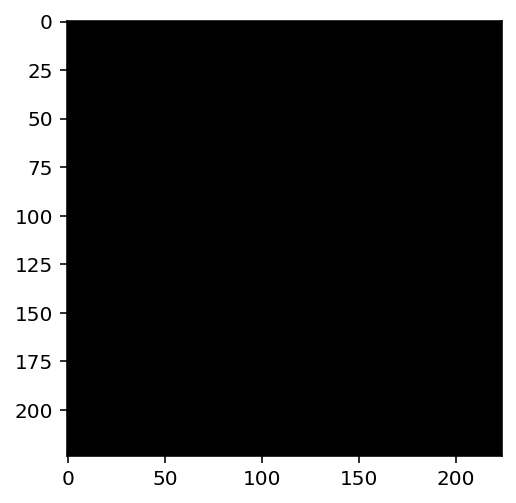

In [159]:
# Display a thresholded mask

test_img = test_preds[1, :, :,:]

plt.imshow(test_img, cmap='gray')